In [1]:
from qiskit import *
# Version
print(qiskit.__qiskit_version__)
from qiskit import IBMQ
from qiskit.tools.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
%matplotlib inline

{'qiskit-terra': '0.17.4', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.13.1', 'qiskit-aqua': '0.9.1', 'qiskit': '0.26.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}


In [ ]:
# API Token
from dotenv import load_dotenv
import os

load_dotenv()

API_TOKEN = os.getenv("IBM_API_TOKEN")

IBMQ.save_account(API_TOKEN, overwrite=True)

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
nqubits = 3
ncbits = 3

circuit = QuantumCircuit(nqubits, ncbits)

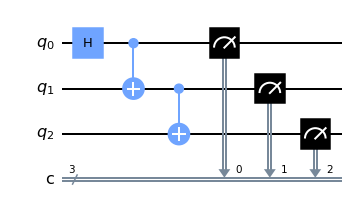

In [4]:
circuit.h(0)
circuit.cx(0,1)
circuit.cx(1,2)
circuit.measure(range(nqubits), range(ncbits))
circuit.draw(output='mpl');

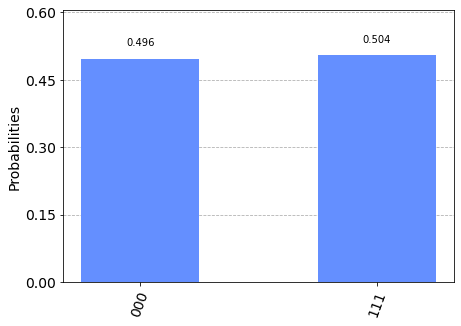

In [5]:
# Run simulator
simulator = simulator = Aer.get_backend('qasm_simulator')
result = execute(experiments=circuit, backend=simulator, shots=1024).result()
counts = result.get_counts(circuit)
plot_histogram(counts);

Job Status: job has successfully run


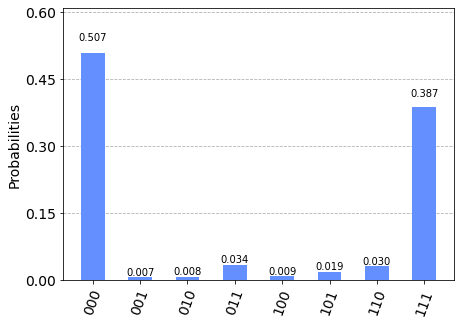

In [6]:
# Execute on quantum computer
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_manila')
# Execute circut on quantum computer
job = execute(experiments=circuit, backend=qcomp, shots=1024)
job_monitor(job)
# Plot result
qresult = job.result()
counts = qresult.get_counts(circuit)
plot_histogram(counts);

In [7]:
# Noise mitigation
cal_circuits, state_labels = complete_meas_cal(qr=circuit.qregs[0], circlabel='measerrormitigationcal')

calib_job = execute(experiments=cal_circuits, 
                    backend=qcomp,
                    shots=1024,
                    optimization_level=0)
job_monitor(calib_job)
# Plot result
calib_result = calib_job.result()

Job Status: job has successfully run


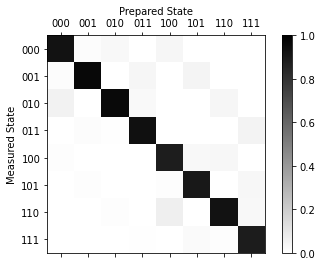

In [8]:
meas_fitter = CompleteMeasFitter(calib_result, state_labels)
meas_fitter.plot_calibration()

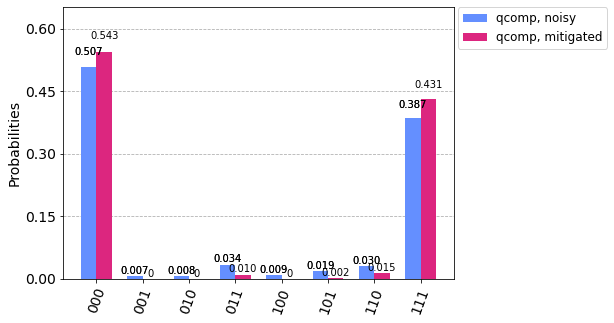

In [9]:
meas_filter = meas_fitter.filter
mitigated_result = meas_filter.apply(qresult)
mitigated_counts = mitigated_result.get_counts(circuit)
plot_histogram([counts, mitigated_counts], legend=['qcomp, noisy', 'qcomp, mitigated']);